# Imports



In [3]:
# imports
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn import set_config
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error
from tabulate import tabulate
from sklearn.inspection import permutation_importance

# Configuring General Settings

In [4]:
warnings.filterwarnings("ignore")
set_config(transform_output="pandas")
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")

# Loading Data

In [5]:
df_sales = pd.read_csv("data/train_v9rqX0R.csv")

# EDA & Data Cleaning

In [6]:
print(df_sales.shape)
df_sales.head()

(8523, 12)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [7]:
# data shape
df_sales.shape

(8523, 12)

In [8]:
# data types
df_sales.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [9]:
# Change the "Outlet_Establishment_Year" feature type
df_sales.Outlet_Establishment_Year = df_sales.Outlet_Establishment_Year.astype("str")

In [10]:
# check if there are duplicates
df_sales.duplicated().sum()

0

In [11]:
# normalized numbers of missing values
sr_nan = (df_sales.isna().sum())/df_sales.shape[0]
sr_nan[sr_nan!=0].round(2)

Item_Weight    0.17
Outlet_Size    0.28
dtype: float64

In [12]:
def replace_nan_id(df, id, column):
    index = df.index
    values = df.groupby(id).first()[column]
    values_dict = values.to_dict()
    df_reindexed = df.set_index(id)
    df_addressed = df_reindexed[column].fillna(values_dict).reset_index()
    return df_addressed.reindex(index)[column]

In [13]:
# replace missing values depending on the ids
df_sales["Item_Weight"] = replace_nan_id(df_sales, "Item_Identifier", "Item_Weight")
df_sales["Outlet_Size"] = replace_nan_id(df_sales, "Outlet_Identifier", "Outlet_Size")

In [14]:
# normalized numbers of missing values after replacement
sr_nan = (df_sales.isna().sum())/df_sales.shape[0]
sr_nan[sr_nan!=0].round(4)

Item_Weight    0.0005
Outlet_Size    0.2828
dtype: float64

the number of missing values for the "Item_Weight" feature is not significant so can drop the correspondent rows

In [15]:
# drop rows with missing values for the "Item_Weight" feature
df_sales.dropna(subset="Item_Weight", inplace=True)

In [16]:
# drop useless features
df_sales.drop(columns=["Item_Identifier","Outlet_Identifier"], inplace=True)

In [17]:
# categorical features cardinalities
cat_cols = df_sales.select_dtypes("object").columns.delete(0)
for c in cat_cols :
    print(f"* {c}: {len(df_sales[c].unique())}")

* Item_Type: 16
* Outlet_Establishment_Year: 9
* Outlet_Size: 4
* Outlet_Location_Type: 3
* Outlet_Type: 4


In [18]:
# check for inconsistencies in classes
df_count = pd.DataFrame
for c in cat_cols :
  print(f"* {c}: {df_sales[c].unique()}")

* Item_Type: ['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
* Outlet_Establishment_Year: ['1999' '2009' '1998' '1987' '1985' '2002' '2007' '1997' '2004']
* Outlet_Size: ['Medium' None 'High' 'Small']
* Outlet_Location_Type: ['Tier 1' 'Tier 3' 'Tier 2']
* Outlet_Type: ['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']


In [19]:
# fixing inconsistent categories of data
df_sales.replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg':'Regular'}, inplace=True)

In [20]:
# number of samples for categorical features classes
cat_cols = df_sales.select_dtypes("object").columns
for c in cat_cols:
  print(f"* {c}:\n{df_sales[c].value_counts()}\n")

* Item_Fat_Content:
Low Fat    5516
Regular    3003
Name: Item_Fat_Content, dtype: int64

* Item_Type:
Fruits and Vegetables    1232
Snack Foods              1199
Household                 910
Frozen Foods              855
Dairy                     681
Canned                    649
Baking Goods              647
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

* Outlet_Establishment_Year:
1985    1459
1987     932
1999     930
1997     930
2004     930
2002     929
2009     928
2007     926
1998     555
Name: Outlet_Establishment_Year, dtype: int64

* Outlet_Size:
Medium    2790
Small     2387
High       932
Name: Outlet_Size, dtype: int64

* Outlet_Location_Type:
Tier 3    3347
Tier 2    2785
Tier 1    2387
Name: Outlet_Location_Type, dty

In [21]:
# Types of outlets with missing values for the size
df_nan_type = df_sales[df_sales.Outlet_Size.isna()].Outlet_Type.unique()
df_nan_type

array(['Grocery Store', 'Supermarket Type1'], dtype=object)

<Axes: xlabel='Outlet_Type', ylabel='Outlet_Size'>

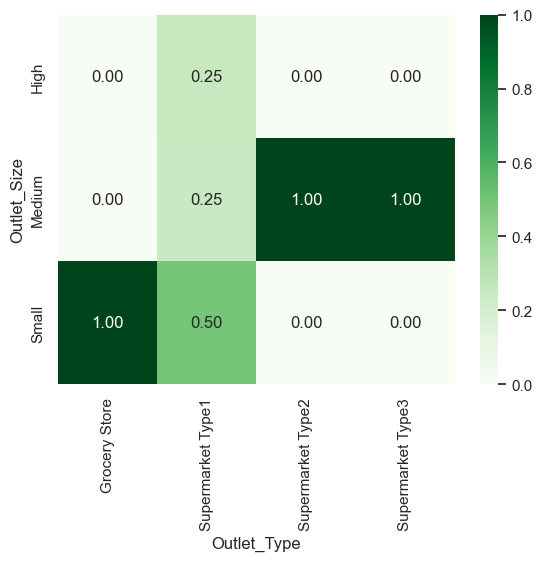

In [22]:
# contingency matrix
contingency_table = pd.crosstab(df_sales['Outlet_Size'],df_sales['Outlet_Type'], normalize="columns")
sns.heatmap(contingency_table, vmin=0, vmax=1, annot=True, fmt=".2f", cmap="Greens")

Grocery stores are all small and supermarkets type 1 are more likely to be small

In [23]:
# replacing missing outlets sizes
df_sales.Outlet_Size.fillna("Small", inplace=True)

In [24]:
def combine_classes(data, features, treshold, rep_class, special_classes=[]):
  data[features] = data[features].replace(special_classes, rep_class)
  for cf in features:
      cardinal_classes = data[cf].value_counts()
      n_classes = len(data[cf].dropna().unique())
      if n_classes==1:
          data.drop(columns=cf, inplace=True)
          print(f'- "{cf}" feature was dropped, it is constant')
      class_to_rep = cardinal_classes[cardinal_classes<treshold].index
      n_class_to_rep = len(class_to_rep)
      if n_class_to_rep != 0:
          n = n_classes - n_class_to_rep
          if n==0 :
              data.drop(columns=cf, inplace=True)
              print(f'- "{cf}" feature was dropped, all classes are not representative')
          else:
              data[cf] = data[cf].replace(class_to_rep, rep_class)
              if (n==1) and (data[cf].value_counts()[rep_class] < treshold):
                  data.drop(columns=cf, inplace=True)
                  print(f'- "{cf}" feature was dropped, minority class is not representative')
              elif data[cf].value_counts()[rep_class] < treshold:
                  last_class_over_tresh = cardinal_classes[cardinal_classes>=treshold].index[-1]
                  data[cf] = data[cf].replace(last_class_over_tresh, rep_class)
                  print(f'- "{last_class_over_tresh}" class of the "{cf}" feature has been changed to "{rep_class}"')

In [25]:
# combine classes
cat_cols = df_sales.select_dtypes("object").columns.delete(2)
combine_classes(df_sales, cat_cols, 800, "other")

In [26]:
# combine "1998" and "1999" "Outlet_Establishment_Year" feature classes
df_sales.Outlet_Establishment_Year.replace([1998, 1999], "1998-1999", inplace=True)

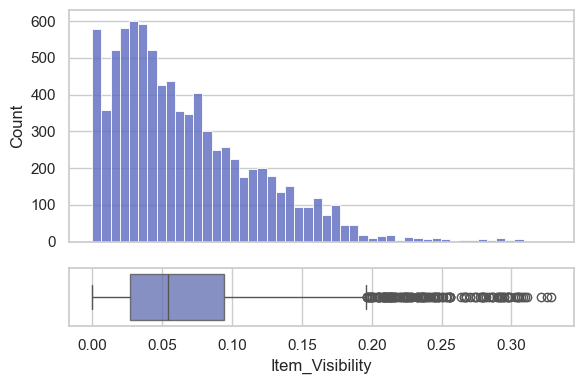

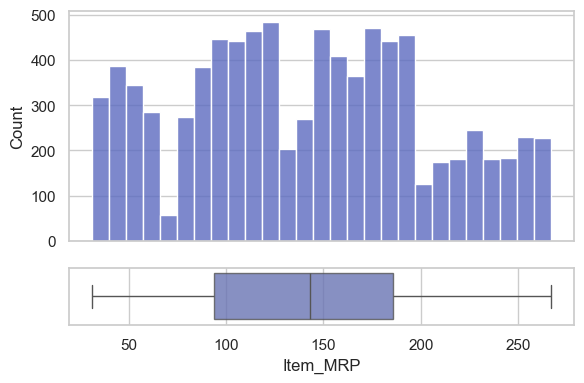

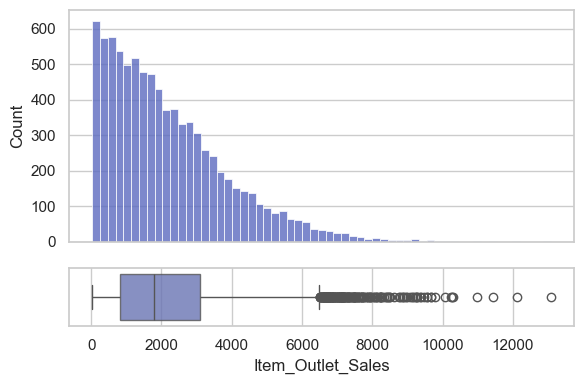

In [27]:
# histograms and boxplots of numerical variables
num_cols = df_sales.select_dtypes("float").columns.delete(0)
for c in num_cols:
  gridspec = {'height_ratios':[0.8,0.2]}
  fig, axes = plt.subplots(nrows=2, figsize=(6,4),
                           sharex=True, gridspec_kw=gridspec)
  sns.histplot(data=df_sales, x=c, color="#5C6BC0", alpha=0.8, ax=axes[0])
  sns.boxplot(data=df_sales, x=c, color="#5C6BC0", boxprops=dict(alpha=0.8),
              ax=axes[1])
  axes[0].grid(axis="x")
  fig.tight_layout()
  plt.show()

Text(0.5, 1.0, 'Numerical Features Correlations')

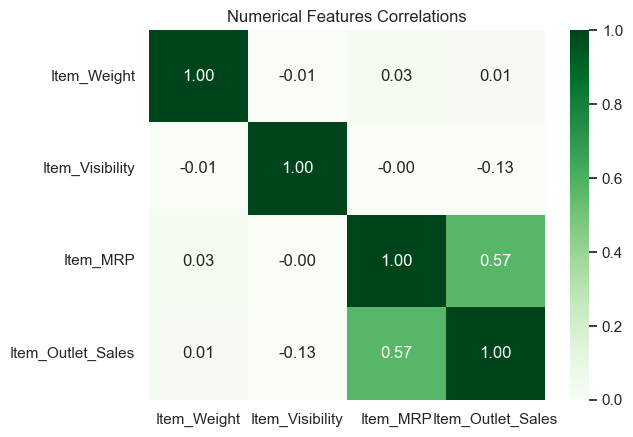

In [28]:
# numerical variables correlations
corr_matrix = df_sales.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="Greens", vmin=0, vmax=1)
plt.title("Numerical Features Correlations")

There is no correlation between each pair of numerical features and target

# Data Explanation

Text(0.5, 1.0, 'Outlet Size vs. Mean Sales')

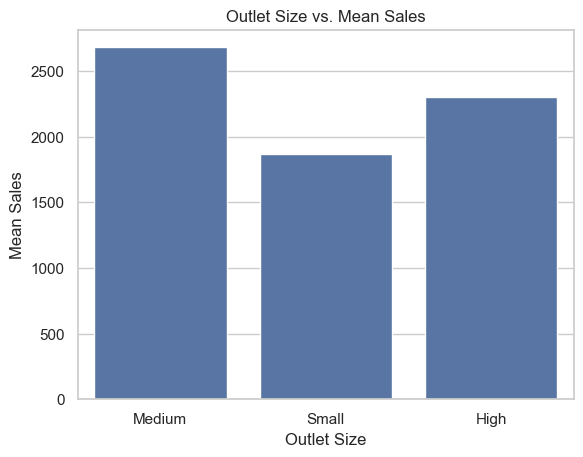

In [32]:
sns.barplot(data=df_sales, x="Outlet_Size", y="Item_Outlet_Sales", errorbar=None)
plt.xlabel("Outlet Size")
plt.ylabel("Mean Sales")
plt.title("Outlet Size vs. Mean Sales")

We see that sales increase in medium stotes and decrease in small ones.

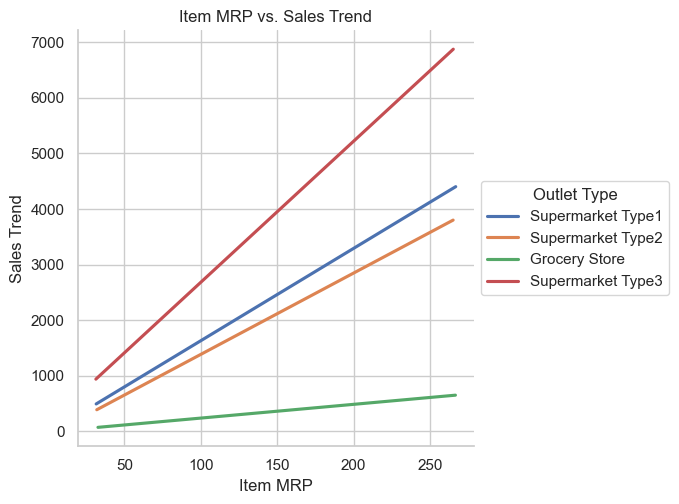

In [33]:
ax = sns.lmplot(data=df_sales, x="Item_MRP", y="Item_Outlet_Sales", hue="Outlet_Type",
                legend=False, scatter=False, ci=None)
plt.xlabel("Item MRP")
plt.ylabel("Sales Trend")
plt.title("Item MRP vs. Sales Trend")
plt.legend(title= "Outlet Type", loc='center left', bbox_to_anchor=(1, 0.5))

Sales trend increase linearly with the item price for each type of store

# Modeling & Data Preprocessing

In [ ]:
# defining features and target
X = df_sales.drop(columns="Item_Outlet_Sales")
y = df_sales.Item_Outlet_Sales

In [ ]:
# splitting dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [ ]:
# define a beseline model
dummy_reg = DummyRegressor(strategy='mean')

In [ ]:
# define different parameters for models
linear_reg_params = dict(linear_reg__positive=[True, False])
knn_params = dict(knn__n_neighbors=[2, 5, 20, 50, 100])
decision_tree_params = dict(decision_tree__max_depth=[None, 5, 50, 200],
                            decision_tree__min_samples_split=[2, 20, 50, 100])
random_forest_params = dict(random_forest__n_estimators=[5, 50, 100],
                            random_forest__max_depth=[None, 5, 50, 200],
                            random_forest__max_features=[1.0, 0.2, 0.5])
adaboost_params = dict(adaboost__n_estimators= [50, 100],
                       adaboost__learning_rate=[1.0, 0.5])
xgboost_params = dict(xgboost__n_estimators= [100, 200, 400],
                                   xgboost__max_depth=[6,20, 100],
                                   xgboost__learning_rate= [0.3, 0.1])
stacking_regressor_params = dict(stacking_regressor__estimators = [[('rf', RandomForestRegressor()),
                                  ('svr',LinearSVR())],
                                   [('rf', RandomForestRegressor(n_estimators=50)),
                                  ('svr', LinearSVR())]])

In [ ]:
models_dict = dict(linear_reg=[LinearRegression(), linear_reg_params],
                   knn=[KNeighborsRegressor(), knn_params],
                   decision_tree=[DecisionTreeRegressor(), decision_tree_params],
                   random_forest=[RandomForestRegressor(), random_forest_params],
                   adaboost=[AdaBoostRegressor(), adaboost_params],
                   xgboost=[XGBRegressor(), xgboost_params],
                   stacking_regressor=[StackingRegressor(estimators=[('rf', RandomForestRegressor()),
                                  ('svr', LinearSVR())]), stacking_regressor_params])

In [ ]:
# define numerical columns
num_cols = X_train.select_dtypes(float).columns
# define categorical columns
cat_cols = X_train.select_dtypes(object).columns
# create a column transformer for features
cols_transformer = ColumnTransformer((("num_transformer",StandardScaler(), num_cols),
                                    ("cat_transformer", OneHotEncoder(sparse_output=False), cat_cols)))

# Model Evaluation & Improvement

In [ ]:
# display metrics for regression model
def regression_metrics(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    tab = tabulate([["Metric", "Training Set", "Test Set"],
                  ["r2", r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)],
                  ["MSE", mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)],
                  ["MAE", mean_absolute_error(y_train, y_train_pred), mean_absolute_error(y_test, y_test_pred)],
                  ["RMSE", mean_squared_error(y_train, y_train_pred, squared=False), mean_squared_error(y_test, y_test_pred, squared=False)]],
                headers='firstrow', numalign="left")
    return tab

In [ ]:
# create a pipeline for the baseline model
pipeline_bseline_reg = Pipeline([("preprocessor", cols_transformer),("dummy regressor", dummy_reg)])
# baseline model metrics
print(regression_metrics(pipeline_bseline_reg, X_train, X_test, y_train, y_test))

Metric    Training Set    Test Set
--------  --------------  ------------
r2        0               -0.000389328
MSE       2.92413e+06     2.8835e+06
MAE       1348.19         1348.31
RMSE      1710.01         1698.09


In [ ]:
for model in models_dict.keys():
  pipeline = Pipeline([("preprocessor", cols_transformer),(model, models_dict[model][0])])
  pipeline.fit(X_train, y_train)
  print(f"* {pipeline.steps[-1][0]}\n{regression_metrics(pipeline, X_train, X_test, y_train, y_test)}\n")

* linear_reg
Metric    Training Set    Test Set
--------  --------------  -----------
r2        0.562825        0.564133
MSE       1.27836e+06     1.25633e+06
MAE       840.278         826.401
RMSE      1130.64         1120.86

* knn
Metric    Training Set    Test Set
--------  --------------  -----------
r2        0.675341        0.499559
MSE       949344          1.44246e+06
MAE       688.974         857.498
RMSE      974.343         1201.02

* decision_tree
Metric    Training Set    Test Set
--------  --------------  -----------
r2        1               0.178819
MSE       0               2.36695e+06
MAE       0               1073.82
RMSE      0               1538.49

* random_forest
Metric    Training Set    Test Set
--------  --------------  -----------
r2        0.938894        0.553575
MSE       178681          1.28676e+06
MAE       294.23          790.227
RMSE      422.706         1134.36

* adaboost
Metric    Training Set    Test Set
--------  --------------  -----------
r2   

For a default tuing, all models outperform the baseline model and the stacking regressor has the best MAE score (786.73)

In [ ]:
for model in models_dict.keys():
  pipeline = Pipeline([("preprocessor",cols_transformer),(model,models_dict[model][0])])
  grid_search = GridSearchCV(pipeline, models_dict[model][1],
                            scoring=make_scorer(mean_absolute_error), error_score="raise")
  grid_search.fit(X_train, y_train)
  print(f"* {model}\n  - Best Score: {grid_search.best_score_}\n  - Best Parameters: {grid_search.best_params_}")

* linear_reg
  - Best Score: 843.3301347849713
  - Best Parameters: {'linear_reg__positive': False}
* knn
  - Best Score: 947.6523980918613
  - Best Parameters: {'knn__n_neighbors': 2}
* decision_tree
  - Best Score: 1093.9113736306585
  - Best Parameters: {'decision_tree__max_depth': None, 'decision_tree__min_samples_split': 2}
* random_forest
  - Best Score: 1126.63239049753
  - Best Parameters: {'random_forest__max_depth': 5, 'random_forest__max_features': 1, 'random_forest__n_estimators': 5}
* adaboost
  - Best Score: 1009.171094912308
  - Best Parameters: {'adaboost__learning_rate': 1.0, 'adaboost__n_estimators': 50}
* xgboost
  - Best Score: 907.889311129364
  - Best Parameters: {'xgboost__learning_rate': 0.3, 'xgboost__max_depth': 6, 'xgboost__n_estimators': 400}
* stacking_regressor
  - Best Score: 804.4715602549119
  - Best Parameters: {'stacking_regressor__estimators': [('rf', RandomForestRegressor(n_estimators=50)), ('svr', LinearSVR(random_state=42))]}


The stacking regressor has the best score so it is the most generalized model.

In [ ]:
# define stacking model tuned with the best tested parameters
stacking_regressor = StackingRegressor(estimators=[('rf', RandomForestRegressor(n_estimators=50)),
                                    ('svr', LinearSVR())])
# create and fit pipeline
pipeline = Pipeline([("preprocessor",cols_transformer),("stacking regressor",stacking_regressor)])
pipeline.fit(X_train, y_train)
# display metrics
print(regression_metrics(pipeline, X_train, X_test, y_train, y_test))

Metric    Training Set    Test Set
--------  --------------  ----------
r2        0.847247        0.578124
MSE       446670          1.216e+06
MAE       488.758         784.727
RMSE      668.334         1102.73


In [ ]:
# use stacking model with PCA
cols_transformer_pca = ColumnTransformer((("num_transformer", make_pipeline(StandardScaler(),PCA(n_components=0.95)), num_cols),
                                    ("cat_transformer", OneHotEncoder(sparse_output=False), cat_cols)))
pipeline_pca = Pipeline([("preprocessor",cols_transformer_pca),("stacking regressor with PCA", stacking_regressor)])
pipeline_pca.fit(X_train, y_train)
print(regression_metrics(pipeline_pca, X_train, X_test, y_train, y_test))

Metric    Training Set    Test Set
--------  --------------  -----------
r2        0.823825        0.577314
MSE       515160          1.21834e+06
MAE       525.625         796.644
RMSE      717.746         1103.78


The performance of the model decreased by PCA

# Model Interpretation

The R2 score shows that the model is explaining about 56% of the variance  in the target which is not perfect. Depending on the MAE score, the model tends to make an error of about 812$, and since the root mean squared error is significantly higher than the mean absolute error, this shows us that it has made some larger errors on some samples.

In [ ]:
# features importances depending on features permutation importances
pipeline = Pipeline([("preprocessor",cols_transformer),("stacking regressor",stacking_regressor)])
pipeline.fit(X_train, y_train)
result = permutation_importance(pipeline, X_train, y_train, scoring=make_scorer(mean_absolute_error), n_repeats=15,
                                random_state=56)
data = list(zip(X_train.columns, result["importances_mean"]*-1))
df_importances = pd.DataFrame(data, columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)
df_importances

,Feature,Importance
4,Item_MRP,897.746587
8,Outlet_Type,431.129838
2,Item_Visibility,171.871550
0,Item_Weight,160.704949
5,Outlet_Establishment_Year,157.820695
3,Item_Type,74.992027
7,Outlet_Location_Type,43.069042
6,Outlet_Size,38.988799
1,Item_Fat_Content,24.237248


The item price and the store type are crucial for the model to predict sales.